In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.simulate_markov import simulate_ar1_process
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat

In [3]:
# Set up the Seaborn style
sns.set(style="whitegrid")

In [4]:
# Fix the random seed for reproducibility 
random_seed = 20
np.random.seed(random_seed)

The following simulation generates two independent and identically distributed $AR(1)$ processes ($Y_t$ and $Z_t$), plots both processes and calculates the maximum cumulative difference between the two processes until a given time, that is, an approximation of $||Y_t-Z_t||_{\infty}$.



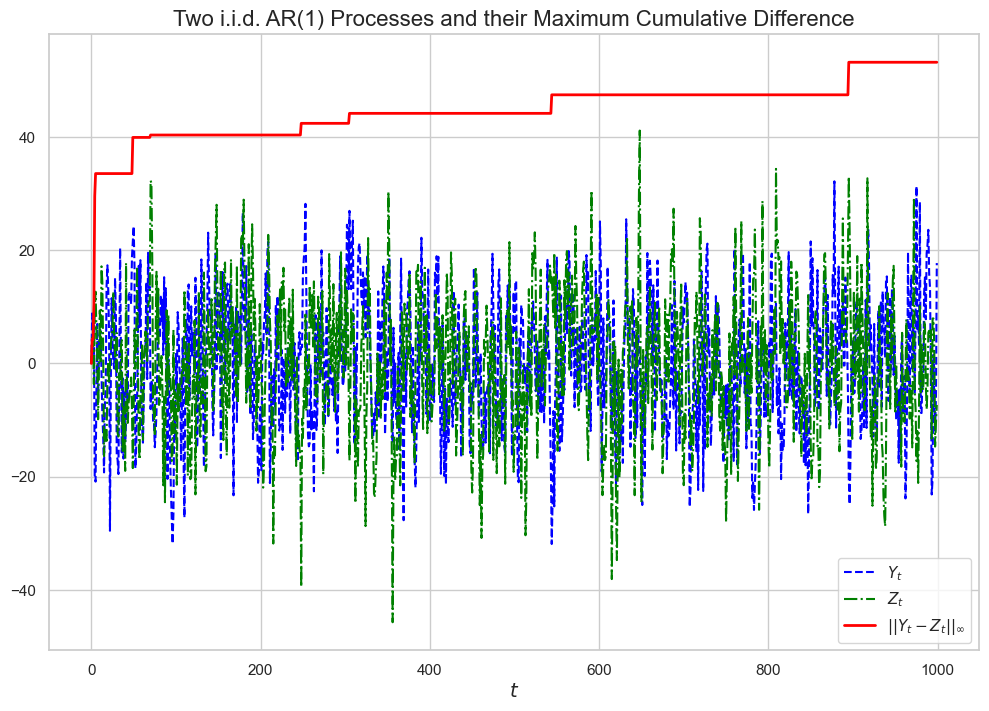

In [5]:
# Set the parameters for the AR(1) process
phi = 0.5
sigma = 10  # Standard deviation of the noise
n_steps = 10**3  # Number of points to simulate

# Set a common initial value for both processes
common_initial_value = 0

processes = simulate_ar1_process(n_steps, phi, sigma, common_initial_value, 2, seed=random_seed)
Y = processes[0]
Z = processes[1]

# Calculate the absolute differences and the cumulative maximum difference
abs_diff = np.abs(Y - Z)
max_diff_cumulative = np.maximum.accumulate(abs_diff)

# Plotting with high contrast colors and LaTeX labels
plt.figure(figsize=(12, 8))
plt.plot(Y, label=r'$Y_t$', linestyle='--', color='blue')
plt.plot(Z, label=r'$Z_t$', linestyle='-.', color='green')
plt.plot(max_diff_cumulative, label=r'$||Y_t-Z_t||_{\infty}$', color='red', linewidth=2)
plt.xlabel(r'$t$', fontsize=14)
plt.title('Two i.i.d. AR(1) Processes and their Maximum Cumulative Difference', fontsize=16)
plt.legend(loc='lower right')
plt.show()


In order to estimate the behaviour of $||Y_t-Z_t||_{\infty}$, we will generate $n=10^3$ simulations of the previous experiment and calculate the maximum difference for each simulation.



In [28]:
n_simulations = 10**4

In [29]:
# Run simulations in parallel
with ProcessPoolExecutor() as executor:
    results = list(executor.map(simulate_ar1_process, 
                                repeat(n_steps, n_simulations),
                                repeat(phi, n_simulations),
                                repeat(sigma, n_simulations),
                                repeat(common_initial_value, n_simulations),
                                repeat(2, n_simulations),
                                np.random.randint(0, 2**32, n_simulations)))


KeyboardInterrupt: 

Now we will plot the average of $||Y_t-Z_t||_{\infty}$ as a function of the number of steps.

In [ ]:
max_diffs_all_simulations = np.zeros((n_simulations, n_steps))
for sim in range(n_simulations):
    Y, Z = results[sim]
    max_diffs_all_simulations[sim, :] = np.maximum.accumulate(np.abs(Y - Z))
# Calculate the expected maximum difference at each time step
expected_max_diffs = np.mean(max_diffs_all_simulations, axis=0)

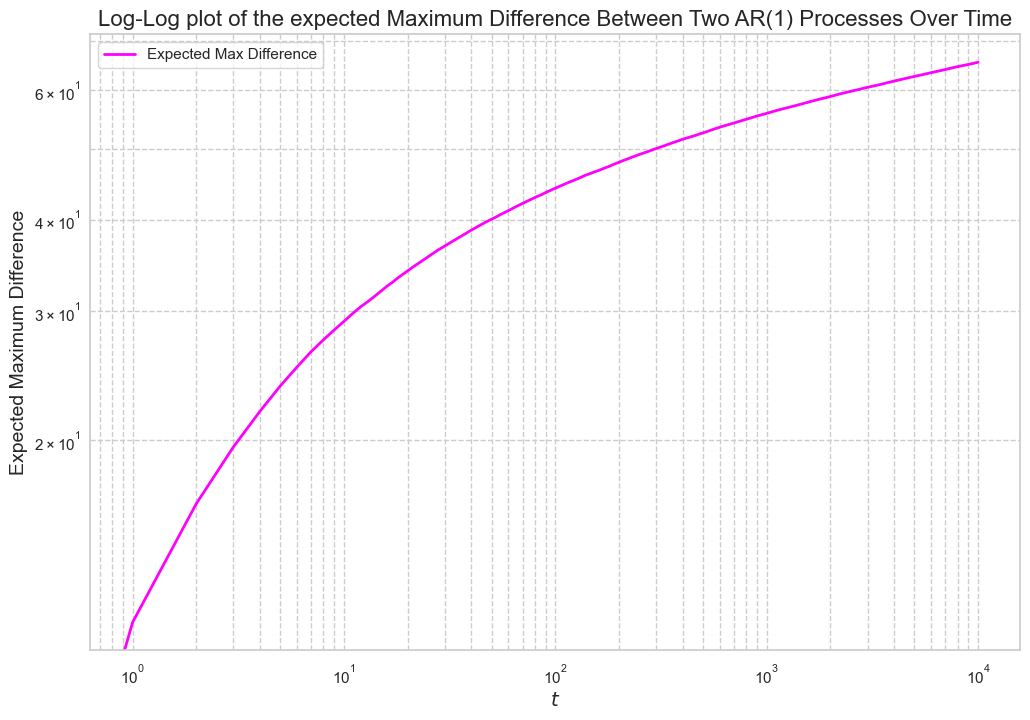

In [ ]:
# Plotting the expected maximum difference using a log-log plot
plt.figure(figsize=(12, 8))
plt.loglog(expected_max_diffs, label='Expected Max Difference', color='magenta', linewidth=2)
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel('Expected Maximum Difference', fontsize=14)
plt.title('Log-Log plot of the expected Maximum Difference Between Two AR(1) Processes Over Time', fontsize=16)
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

The next plots show the estimated distribution of $||Y_t-Z_t||_{\infty}$ as a function of the number of steps used for the estimation.

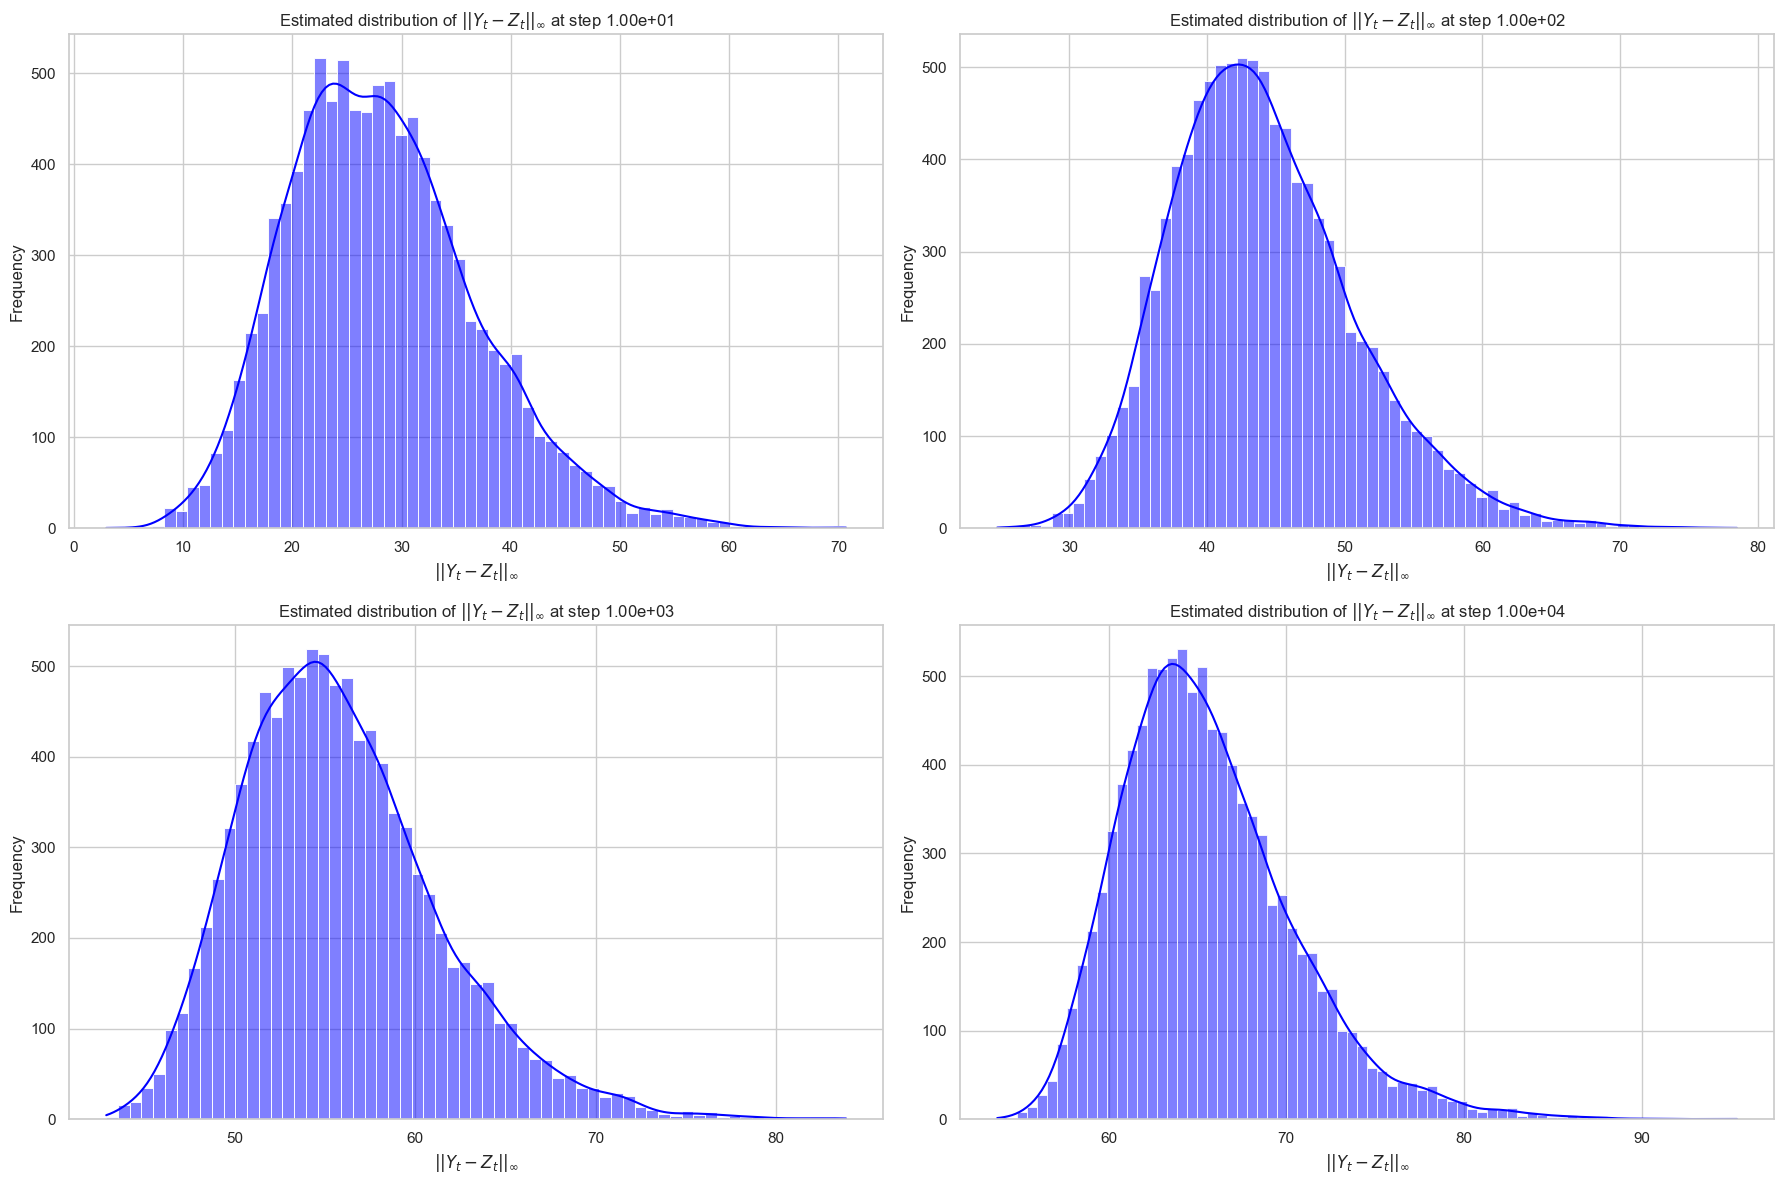

In [ ]:
start_step = 10  # Start at 10 steps
selected_steps = np.logspace(np.log10(start_step), np.log10(n_steps), 4, dtype=int)  # Select 4 time steps using logspace

# Set up plotting
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # Create a subplot grid
axes = axes.flatten()  # Flatten the array of axes

for i, step in enumerate(selected_steps):
    sns.histplot(max_diffs_all_simulations[:, step-1], ax=axes[i], kde=True, color='blue')
    axes[i].set_title(r'Estimated distribution of $||Y_t-Z_t||_{\infty}$ at step '+f'{step:.2e}')  # Use scientific notation with 2 decimal places for the step number
    axes[i].set_xlabel(r'$||Y_t-Z_t||_{\infty}$')
    axes[i].set_ylabel('Frequency')

# Remove extra subplot (if any)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()